In [1]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

# taks: classify euro coins
* data was downloaded using googleimagesdownload
* search term was "denomination" + "coin/Münze/..." + "year number"

# define data generator

In [2]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    vertical_flip=True
)

# search for training data

In [3]:
train_dir = "./data"
IMG_HEIGHT, IMG_WIDTH = 224, 224
batch_size = 32

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 1271 images belonging to 8 classes.


# found classes

In [4]:
print(train_data_gen.class_indices)

{'10_cent': 0, '1_cent': 1, '1_euro': 2, '20_cent': 3, '2_cent': 4, '2_euro': 5, '50_cent': 6, '5_cent': 7}


# display samples from training set
note: data set is not cleaned at all

/home/alessio/prj/hagenberg/block_3/code/venv/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


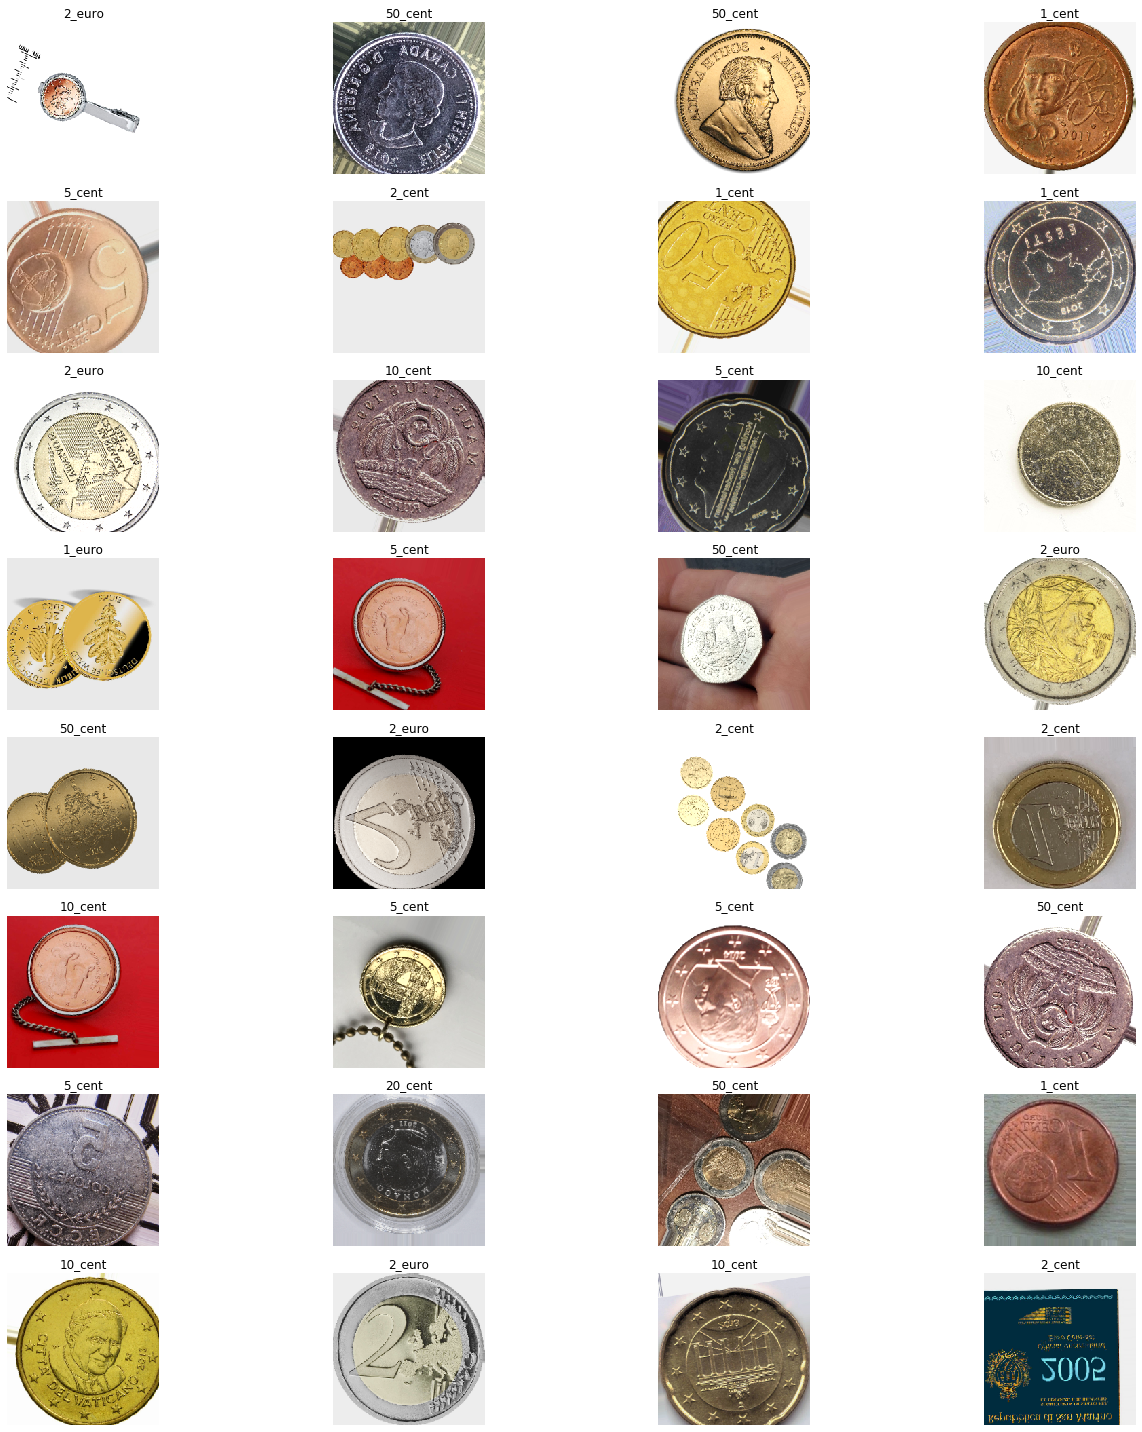

In [5]:
sample_training_images, labels = next(train_data_gen)
class_label = {v:k for k,v in train_data_gen.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

# use pre-trained model

In [6]:
base_model = tf.keras.applications.resnet_v2.ResNet50V2(
        include_top=False,
        pooling='max',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        weights='imagenet')

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(512, 'relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(train_data_gen.num_classes, 'softmax')
])
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 2056      
Total params: 24,747,272
Trainable params: 24,701,832
Non-trainable params: 45,440
_________________________________________________________________


### utility function that will skip batches if there is a broken image in it

In [7]:
def skip_broken_images(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except GeneratorExit:
            break
        except:
            pass

### snapshot callback

In [8]:
snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots",
    verbose=1)

# train only the fully connected layers

In [14]:
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

history = model.fit_generator(
    skip_broken_images(train_data_gen),
    steps_per_epoch=2, #use way more steps here: number of samples / batch size
    epochs=3, #use way more or use EarlyStopping callback
    callbacks=[snapshot_callback]
)

Epoch 1/3
1/2 [==============>...............] - ETA: 16s - loss: 14.5047 - categorical_accuracy: 0.0938
Epoch 00001: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots/assets
2/2 [==============================] - 52s 26s/step - loss: 14.3988 - categorical_accuracy: 0.0938
Epoch 2/3
1/2 [==============>...............] - ETA: 9s - loss: 12.5242 - categorical_accuracy: 0.1250
Epoch 00002: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots/assets
2/2 [==============================] - 42s 21s/step - loss: 12.5162 - categorical_accuracy: 0.1719
Epoch 3/3
1/2 [==============>...............] - ETA: 9s - loss: 13.1251 - categorical_accuracy: 0.1562
Epoch 00003: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots/assets
2/2 [==============================] - 42s 21s/step - loss: 14.1179 - categorical_accuracy: 0.1094


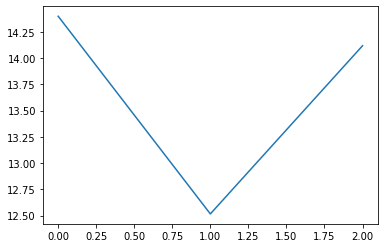

In [15]:
plt.plot(history.history['loss'])

# train complete network

In [16]:
for layer in base_model.layers:
    layer.trainable = True
    
    
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])    

history = model.fit_generator(
    skip_broken_images(train_data_gen),
    steps_per_epoch=2, #use way more steps here: number of samples / batch size
    epochs=3, #use way more or use EarlyStopping callback
    callbacks=[snapshot_callback]
)

Epoch 1/3
1/2 [==============>...............] - ETA: 14s - loss: 14.4845 - categorical_accuracy: 0.0938
Epoch 00001: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots/assets
2/2 [==============================] - 61s 30s/step - loss: 14.5641 - categorical_accuracy: 0.0781
Epoch 2/3
1/2 [==============>...............] - ETA: 11s - loss: 13.5996 - categorical_accuracy: 0.1562
Epoch 00002: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots/assets
2/2 [==============================] - 58s 29s/step - loss: 13.5996 - categorical_accuracy: 0.1562
Epoch 3/3
1/2 [==============>...............] - ETA: 12s - loss: 13.0960 - categorical_accuracy: 0.1875
Epoch 00003: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots/assets
2/2 [==============================] - 57s 29s/step - loss: 13.5996 - categorical_accuracy: 0.1562


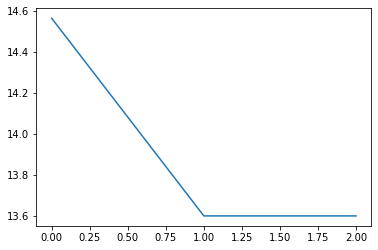

In [17]:
plt.plot(history.history['loss'])

# save final model

In [18]:
model.save('coin_model_resnet_50.h5')